In [1]:
%matplotlib inline
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

Loading the data

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

Initial Data Exploration

In [3]:
train_df.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [5]:
# Checking for null values
null_counts = train_df.isnull().sum()
null_counts

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [6]:
train_df.shape

(1458644, 11)

In [7]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


**Data Preperation**

Trip Duration Clean Up:

As we noted earlier there are some outliers associated with the `trip_duration` variable, specifically a 980 hour maximum trip duration and a minimum of 1 second trip duration. So, I have decided to exclude data that lies outside 2 standard deviations from the mean.

In [8]:
m = np.mean(train_df['trip_duration'])
s = np.std(train_df['trip_duration'])
train_df = train_df[train_df['trip_duration'] <= m + 2*s]
train_df = train_df[train_df['trip_duration'] >= m - 2*s]
train_df.shape

(1456540, 11)

Adjusting the latitude and longitude in realtion to the actual latitudes and longitudes of New York city

Actual range for Latitudes and Longitudes:

city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

In [9]:
train_df = train_df[train_df['pickup_longitude'] <= -73.75]
train_df = train_df[train_df['pickup_longitude'] >= -74.03]
train_df = train_df[train_df['pickup_latitude'] <= 40.85]
train_df = train_df[train_df['pickup_latitude'] >= 40.63]
train_df = train_df[train_df['dropoff_longitude'] <= -73.75]
train_df = train_df[train_df['dropoff_longitude'] >= -74.03]
train_df = train_df[train_df['dropoff_latitude'] <= 40.85]
train_df = train_df[train_df['dropoff_latitude'] >= 40.63]
train_df.shape

(1437128, 11)

**Feature extraction**

In [10]:
# converting the Datetime in the dtatframe from sting to pandas datetime format for future use
train_df['pickup_datetime'] = pd.to_datetime(train_df.pickup_datetime)
train_df['dropoff_datetime'] = pd.to_datetime(train_df.dropoff_datetime)
test_df['pickup_datetime'] = pd.to_datetime(test_df.pickup_datetime)

# Extracting date from pickup_datetime and Dropoff_datetime
train_df.loc[:,'pickup_date'] = train_df['pickup_datetime'].dt.date
test_df.loc[:,'pickup_date'] = test_df['pickup_datetime'].dt.date

print(train_df.shape)
train_df.head(5)


(1437128, 12)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,2016-03-14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,2016-06-12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,2016-01-19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,2016-04-06
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,2016-03-26


Extracting time based features:

1. day of the week
2. Hour of the day
3. month

In [11]:
# Extracting weekday, month and hour in train_df from pickup_duration
train_df['pickup_day_of_week'] = train_df['pickup_datetime'].dt.dayofweek
train_df['pickup_hour'] = train_df['pickup_datetime'].dt.hour
train_df['pickup_month'] = train_df['pickup_datetime'].dt.month

# Extracting weekday, month and hour in train_df from dropoff_duration
train_df['dropoff_day_of_week'] = train_df['dropoff_datetime'].dt.dayofweek
train_df['dropoff_hour'] = train_df['dropoff_datetime'].dt.hour
train_df['dropoff_month'] = train_df['dropoff_datetime'].dt.month

print(train_df.shape)
train_df.head(5)

(1437128, 18)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day_of_week,pickup_hour,pickup_month,dropoff_day_of_week,dropoff_hour,dropoff_month
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,2016-03-14,0,17,3,0,17,3
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,2016-06-12,6,0,6,6,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,2016-01-19,1,11,1,1,12,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,2016-04-06,2,19,4,2,19,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,2016-03-26,5,13,3,5,13,3


**Creating Additional features**

Categorize the time of day (morning, afternoon, evening, night) based on pickup_hour.

Day of Week:
 Categorize days into weekday or weekend.

In [12]:
# Ctegorizing days into weekday and weekend
def categorize_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

train_df['pickup_time_of_day'] = train_df['pickup_hour'].apply(categorize_time_of_day)

# Categorizing hours into morning, afternnon, evening and night
def categorize_day(day):
    if day < 5:  # Weekdays (Monday=0, Tuesday=1, ..., Friday=4)
        return 'Weekday'
    else:        # Weekend (Saturday=5, Sunday=6)
        return 'Weekend'

# Apply the function to the 'pickup_datetime' column
train_df['pickup_day_type'] = train_df['pickup_day_of_week'].apply(categorize_day)


In [13]:
#train_df = train_df.drop(columns='pdropoff_hour')
print(train_df.shape)
train_df.head(5)


(1437128, 20)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day_of_week,pickup_hour,pickup_month,dropoff_day_of_week,dropoff_hour,dropoff_month,pickup_time_of_day,pickup_day_type
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,2016-03-14,0,17,3,0,17,3,Evening,Weekday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,2016-06-12,6,0,6,6,0,6,Night,Weekend
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,2016-01-19,1,11,1,1,12,1,Morning,Weekday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,2016-04-06,2,19,4,2,19,4,Evening,Weekday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,2016-03-26,5,13,3,5,13,3,Afternoon,Weekend


In [14]:
test_df.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_date
0,id3004672,1,2016-06-30 23:59:58,1,-73.988,40.732,-73.990,40.757,N,2016-06-30
1,id3505355,1,2016-06-30 23:59:53,1,-73.964,40.680,-73.960,40.655,N,2016-06-30
2,id1217141,1,2016-06-30 23:59:47,1,-73.997,40.738,-73.986,40.730,N,2016-06-30
3,id2150126,2,2016-06-30 23:59:41,1,-73.956,40.772,-73.986,40.730,N,2016-06-30
4,id1598245,1,2016-06-30 23:59:33,1,-73.970,40.761,-73.962,40.756,N,2016-06-30


In [15]:
# Extracting weekday, month and hour in test_df from pickup_duration
test_df['pickup_day_of_week'] = test_df['pickup_datetime'].dt.dayofweek
test_df['pickup_hour'] = test_df['pickup_datetime'].dt.hour
test_df['pickup_month'] = test_df['pickup_datetime'].dt.month

# Ctegorizing days into weekday and weekend
test_df['pickup_time_of_day'] = test_df['pickup_hour'].apply(categorize_time_of_day)


# Categorizing hours into morning, afternnon, evening and night
test_df['pickup_day_type'] = test_df['pickup_day_of_week'].apply(categorize_day)

print(test_df.shape)
test_df.head(5)

(625134, 15)


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_date,pickup_day_of_week,pickup_hour,pickup_month,pickup_time_of_day,pickup_day_type
0,id3004672,1,2016-06-30 23:59:58,1,-73.988,40.732,-73.990,40.757,N,2016-06-30,3,23,6,Night,Weekday
1,id3505355,1,2016-06-30 23:59:53,1,-73.964,40.680,-73.960,40.655,N,2016-06-30,3,23,6,Night,Weekday
2,id1217141,1,2016-06-30 23:59:47,1,-73.997,40.738,-73.986,40.730,N,2016-06-30,3,23,6,Night,Weekday
3,id2150126,2,2016-06-30 23:59:41,1,-73.956,40.772,-73.986,40.730,N,2016-06-30,3,23,6,Night,Weekday
4,id1598245,1,2016-06-30 23:59:33,1,-73.970,40.761,-73.962,40.756,N,2016-06-30,3,23,6,Night,Weekday


**Calculating the distance travelled by the taxi**

In [16]:
def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers
    return c * r

train_df['distance_km'] = train_df.apply(lambda row: haversine(row['pickup_longitude'], row['pickup_latitude'], row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

In [17]:
print(train_df.shape)
train_df.head(5)

(1437128, 21)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_date,pickup_day_of_week,pickup_hour,pickup_month,dropoff_day_of_week,dropoff_hour,dropoff_month,pickup_time_of_day,pickup_day_type,distance_km
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,...,2016-03-14,0,17,3,0,17,3,Evening,Weekday,1.499
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,...,2016-06-12,6,0,6,6,0,6,Night,Weekend,1.806
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,...,2016-01-19,1,11,1,1,12,1,Morning,Weekday,6.385
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,...,2016-04-06,2,19,4,2,19,4,Evening,Weekday,1.485
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,...,2016-03-26,5,13,3,5,13,3,Afternoon,Weekend,1.189


In [18]:
# Convert duration from seconds to hours
train_df['duration_hours'] = train_df['trip_duration'] / 3600

# Calculate average speed in km/h
train_df['average_speed_kmh'] = train_df['distance_km'] / train_df['duration_hours']

In [19]:
print(train_df.shape)
train_df.head(5)

(1437128, 23)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_month,dropoff_day_of_week,dropoff_hour,dropoff_month,pickup_time_of_day,pickup_day_type,distance_km,duration_hours,average_speed_kmh
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,...,17,3,0,17,3,Evening,Weekday,1.499,0.126,11.856
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,...,0,6,6,0,6,Night,Weekend,1.806,0.184,9.804
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,...,11,1,1,12,1,Morning,Weekday,6.385,0.590,10.822
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,...,19,4,2,19,4,Evening,Weekday,1.485,0.119,12.466
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,...,13,3,5,13,3,Afternoon,Weekend,1.189,0.121,9.837


In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1437128 entries, 0 to 1458643
Data columns (total 23 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   id                   1437128 non-null  object        
 1   vendor_id            1437128 non-null  int64         
 2   pickup_datetime      1437128 non-null  datetime64[ns]
 3   dropoff_datetime     1437128 non-null  datetime64[ns]
 4   passenger_count      1437128 non-null  int64         
 5   pickup_longitude     1437128 non-null  float64       
 6   pickup_latitude      1437128 non-null  float64       
 7   dropoff_longitude    1437128 non-null  float64       
 8   dropoff_latitude     1437128 non-null  float64       
 9   store_and_fwd_flag   1437128 non-null  object        
 10  trip_duration        1437128 non-null  int64         
 11  pickup_date          1437128 non-null  object        
 12  pickup_day_of_week   1437128 non-null  int32         
 13  pi

In [21]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train_df.describe()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_day_of_week,pickup_hour,pickup_month,dropoff_day_of_week,dropoff_hour,dropoff_month,distance_km,duration_hours,average_speed_kmh
count,1437128.000,1437128,1437128,1437128.000,1437128.000,1437128.000,1437128.000,1437128.000,1437128.000,1437128.000,1437128.000,1437128.000,1437128.000,1437128.000,1437128.000,1437128.000,1437128.000,1437128.000
mean,1.534,2016-04-01 09:25:38.913597952,2016-04-01 09:39:23.341459456,1.664,-73.974,40.751,-73.974,40.752,824.428,3.048,13.616,3.516,3.053,13.614,3.516,3.293,0.229,14.222
min,1.000,2016-01-01 00:00:17,2016-01-01 00:03:31,0.000,-74.030,40.630,-74.030,40.630,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000
25%,1.000,2016-02-17 15:47:22.750000128,2016-02-17 16:00:56.750000128,1.000,-73.992,40.737,-73.991,40.736,394.000,1.000,9.000,2.000,1.000,9.000,2.000,1.225,0.109,9.099
50%,2.000,2016-04-01 16:02:11,2016-04-01 16:19:06,1.000,-73.982,40.754,-73.980,40.755,655.000,3.000,14.000,4.000,3.000,14.000,4.000,2.068,0.182,12.718
75%,2.000,2016-05-15 02:59:49.750000128,2016-05-15 03:10:16.500000,2.000,-73.968,40.768,-73.963,40.770,1056.000,5.000,19.000,5.000,5.000,19.000,5.000,3.767,0.293,17.634
max,2.000,2016-06-30 23:59:39,2016-07-01 00:48:20,6.000,-73.751,40.850,-73.750,40.850,11411.000,6.000,23.000,6.000,6.000,23.000,7.000,27.192,3.170,9274.837
std,0.499,NaN,NaN,1.314,0.037,0.027,0.033,0.030,644.690,1.954,6.379,1.681,1.956,6.460,1.681,3.664,0.179,11.225


In [22]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  625134 non-null  object        
 1   vendor_id           625134 non-null  int64         
 2   pickup_datetime     625134 non-null  datetime64[ns]
 3   passenger_count     625134 non-null  int64         
 4   pickup_longitude    625134 non-null  float64       
 5   pickup_latitude     625134 non-null  float64       
 6   dropoff_longitude   625134 non-null  float64       
 7   dropoff_latitude    625134 non-null  float64       
 8   store_and_fwd_flag  625134 non-null  object        
 9   pickup_date         625134 non-null  object        
 10  pickup_day_of_week  625134 non-null  int32         
 11  pickup_hour         625134 non-null  int32         
 12  pickup_month        625134 non-null  int32         
 13  pickup_time_of_day  625134 no

**Data Visualisation**

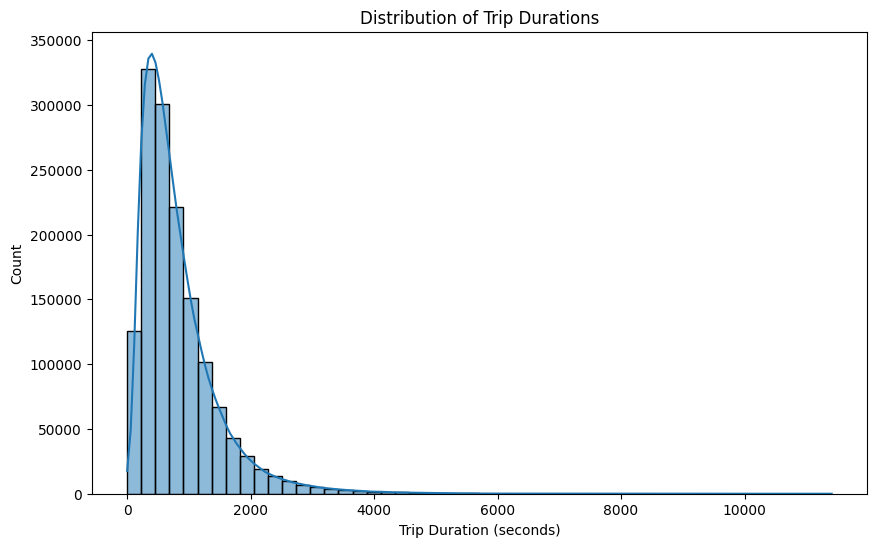

In [23]:
# Trip duration distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='trip_duration', bins=50, kde=True)
plt.title('Distribution of Trip Durations')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Count')
plt.show()


**Observation:** The majority of trips are of shorter duration, as indicated by the high frequency of shorter bars on the left. The distribution is right-skewed, with a long tail extending towards the right, suggesting that while most trips are brief, there are occasional trips with much longer durations. The data shows a clear decrease in frequency as trip duration increases, indicating that longer trips are less common.

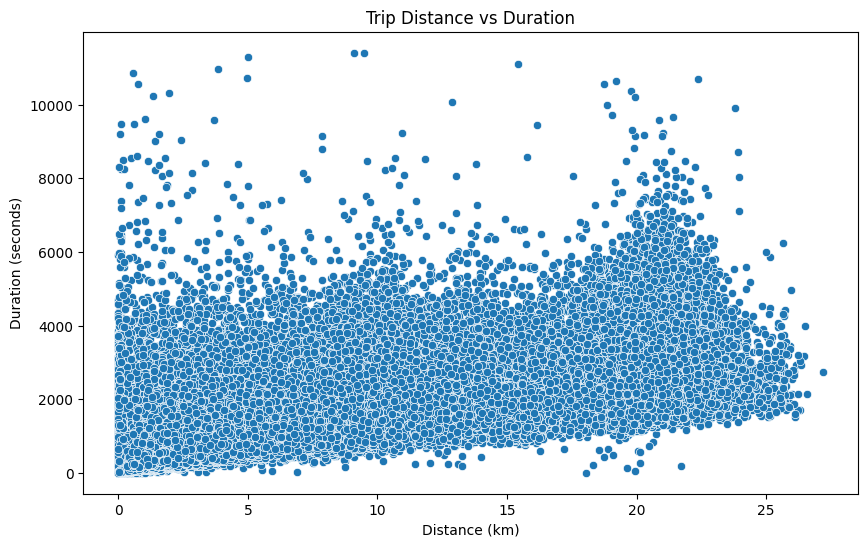

In [24]:
# Distance and trip duration coorelation
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_km', y='trip_duration', data=train_df)
plt.title('Trip Distance vs Duration')
plt.xlabel('Distance (km)')
plt.ylabel('Duration (seconds)')
plt.show()

The scatter plot illustrates a relationship between trip distance and duration for taxi rides. Notably, there is a cluster of points concentrated at the lower end of both axes, indicating a large number of shorter trips both in distance and duration. The plot also shows that as distance increases, there is a general trend of increasing trip duration. However, there's a significant spread in durations for any given distance, particularly for trips under 5 km, suggesting variability in trip speeds—potentially due to factors like traffic, stop lights, and urban driving conditions. For longer distances, the duration spread narrows, indicating a more consistent travel time per kilometer, which might be characteristic of trips that utilize faster routes such as highways. There are few data points for longer distances above 20 km, implying such trips are less common in the dataset.

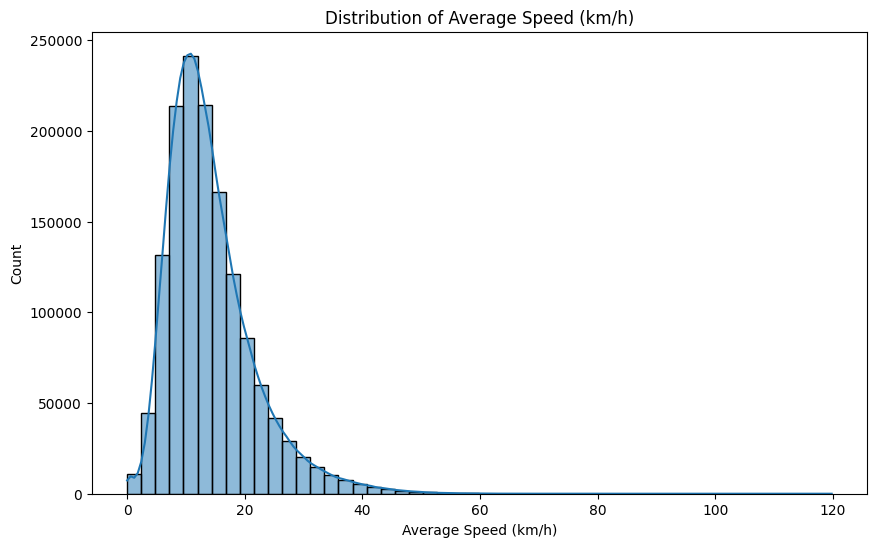

In [25]:
# average speed distribution
# Filter out implausible average speeds, e.g., anything above 120 km/h
reasonable_speeds = train_df[(train_df['average_speed_kmh'] > 0) & (train_df['average_speed_kmh'] <= 120)]

# distribution of reasonable average speeds
plt.figure(figsize=(10, 6))
sns.histplot(data=reasonable_speeds, x='average_speed_kmh', bins=50, kde=True)
plt.title('Distribution of Average Speed (km/h)')
plt.xlabel('Average Speed (km/h)')
plt.ylabel('Count')
plt.show()

The histogram displays the distribution of average speeds (in km/h) for a set of taxi trips. The distribution is unimodal, with a peak around 10-15 km/h, indicating that this is the most common speed range. The frequency of trips decreases as the average speed increases, which is typical for urban taxi trips where lower speeds are common due to factors like traffic congestion. The data shows a long tail towards the higher speeds, but with significantly fewer trips occurring in these ranges. There are very few trips with average speeds close to 120 km/h. The KDE line closely follows the shape of the histogram, emphasizing the concentration of data around the mode and the right-skewed nature of the distribution.


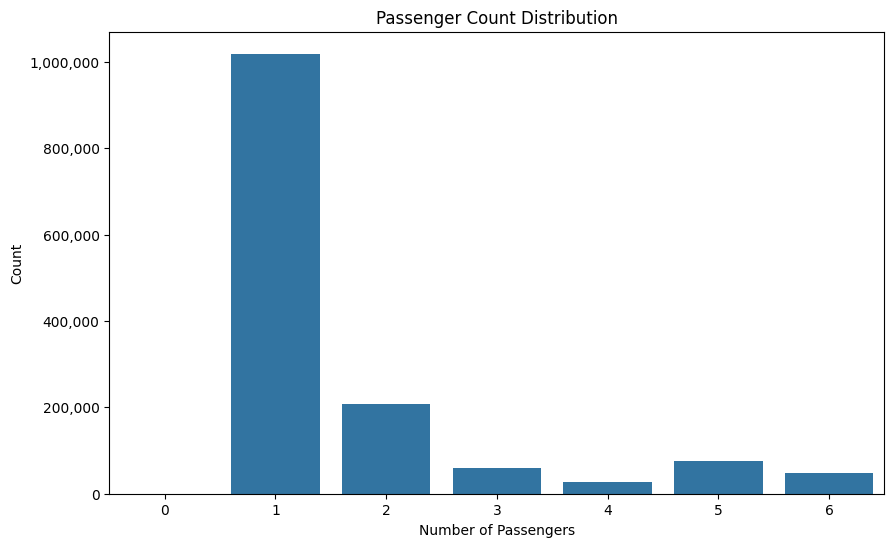

In [26]:
# Passanger count distribution

import matplotlib.ticker as ticker

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='passenger_count', data=train_df)
plt.title('Passenger Count Distribution')
plt.xlabel('Number of Passengers')
plt.ylabel('Count')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()


The provided graph illustrates the distribution of passenger counts in taxi trips. It shows that single-passenger rides are by far the most common, with a count approaching 1 million. The frequency of rides decreases significantly as the number of passengers increases, with two-passenger trips being the next most common, followed by a progressively smaller number of trips with three to six passengers. The graph indicates that higher passenger counts are much less frequent in this taxi dataset.

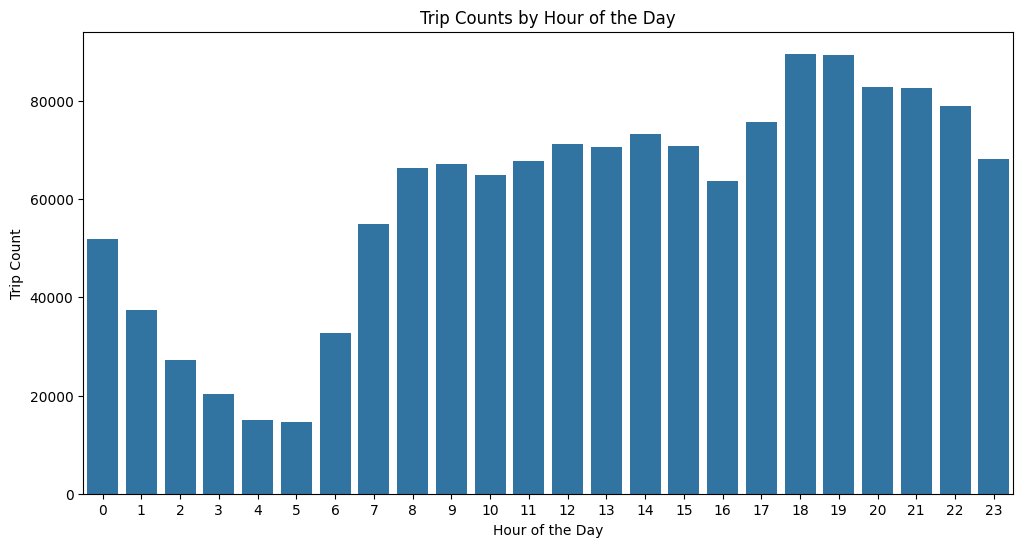

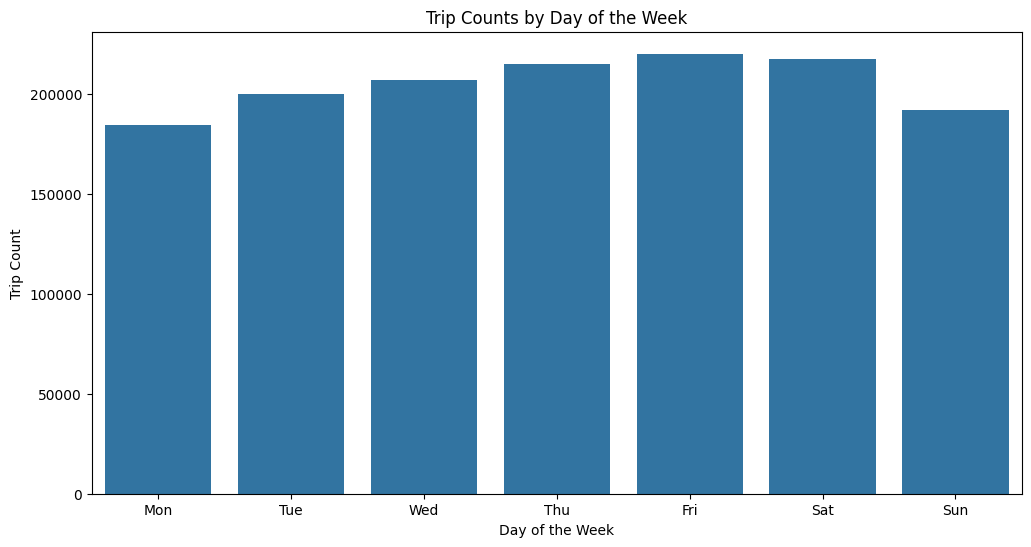

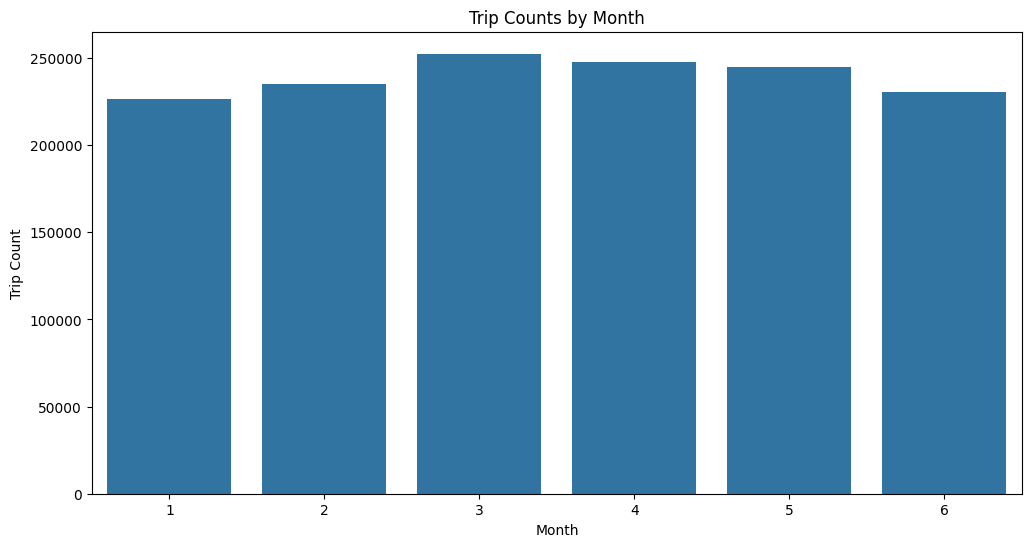

In [27]:
# Visualize how trip counts vary over time (hour of the day, day of the week, months).

# Hour of the day
plt.figure(figsize=(12, 6))
sns.countplot(x='pickup_hour', data=train_df)
plt.title('Trip Counts by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Trip Count')
plt.show()

# Day of the week
plt.figure(figsize=(12, 6))
sns.countplot(x='pickup_day_of_week', data=train_df)
plt.title('Trip Counts by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Trip Count')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

# Month
plt.figure(figsize=(12, 6))
sns.countplot(x='pickup_month', data=train_df)
plt.title('Trip Counts by Month')
plt.xlabel('Month')
plt.ylabel('Trip Count')
plt.show()


1. **Trip count by Hour:** There is a clear trend of increasing trip counts starting from the early morning hours, peaking during the late evening hours. The lowest counts are observed in the early morning (around 5 AM), and the counts steadily rise through the morning and afternoon hours. There's a slight dip after the morning peak, possibly corresponding to mid-day. The highest counts are seen in the evening, starting from around 6 PM and remaining high until midnight. This pattern suggests that taxi usage is lowest in the early morning and highest in the evenings, which may correspond to typical commuting hours and nightlife activities.

2. **Trip count by weekday:** It shows that the number of trips is relatively consistent across weekdays (Monday through Friday), with a slight increase on Friday. The count for Saturday is slightly lower than the weekdays, and Sunday has the lowest number of trips of any day in the week. This pattern suggests a typical urban cycle where taxi usage is steady during the workweek, decreases slightly on Saturday, and drops to the lowest point on Sunday.

3. **Trip count by month:** The trip counts are fairly consistent across the months, with no dramatic fluctuations indicating a stable demand for taxi services throughout these months. Each month's trip count hovers around the 200,000 mark, suggesting a steady usage pattern without significant seasonal impact within the given timeframe. Interestingly, the given data only have information of taxi rides for six months.


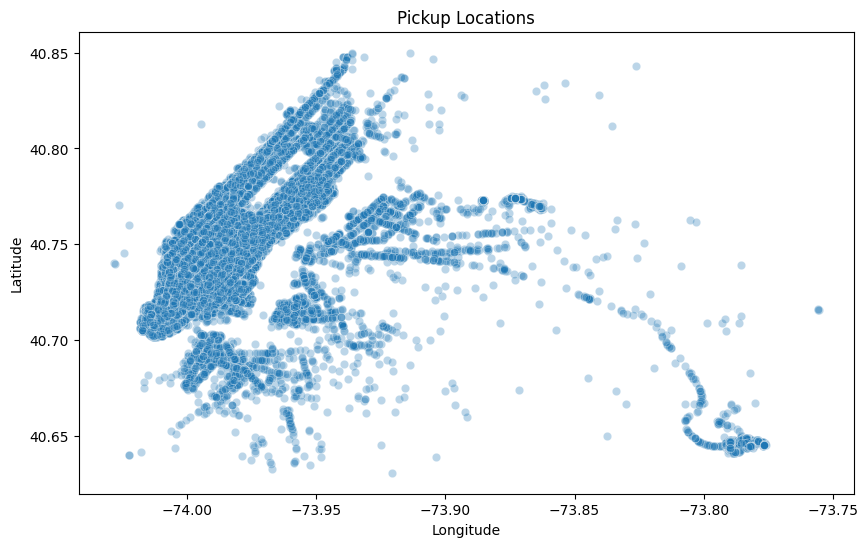

In [28]:
# Plotting pickup and dropoff locations on a map to get insights into hotspots.

sampled_df = train_df.sample(100000)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=sampled_df, alpha=0.3)
plt.title('Pickup Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

The scatter plot shows the geographical distribution of taxi pickup locations based on latitude and longitude coordinates. The plot reveals a high concentration of pickups in areas that resemble the layout of Manhattan, with dense clusters particularly around Midtown and the Upper East and West Sides, as well as a pronounced cluster in Lower Manhattan. There are also notable concentrations around what could be other boroughs, such as Brooklyn and Queens, indicating popular pickup locations or areas with high traffic. The data points are less dense as they move away from these central areas, suggesting fewer pickups in the more peripheral parts of the city. Additionally, the data may indicate popular routes or thoroughfares, reflected by lines of densely plotted points extending from central areas. The visualization effectively maps out the key areas of taxi activity within the city.

In [29]:
# Coorelation matrix

correlation_matrix = train_df.corr()

# You can use seaborn to create a heatmap for better visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()


ValueError: could not convert string to float: 'id2875421'



1. **Strong Positive Correlations**: Some variables show a strong positive correlation, notably between `pickup_longitude` and `dropoff_longitude`, as well as `pickup_latitude` and `dropoff_latitude`, indicating that trips tend to occur within specific geographic boundaries. The `trip_duration` is strongly correlated with `distance_km` and `duration_hours`, which is expected as longer distances would typically take longer to travel.

2. **High Correlation in Time Variables**: The `pickup_hour` and `dropoff_hour` have a very high correlation, suggesting that most trips have short durations, within the same hour. There's also a strong correlation between `pickup_month` and `dropoff_month`, as well as `pickup_day_of_week` and `dropoff_day_of_week`, which is logical since most trips would begin and end within the same day and month.

3. **Moderate Correlations**: `distance_km` has a moderate positive correlation with both `pickup_longitude` and `dropoff_longitude`, and a negative correlation with `pickup_latitude` and `dropoff_latitude`, indicating certain directional trends in the trips taken.

4. **Low or No Correlation**: Many variables show low to no correlation with each other (correlation coefficients close to 0), which suggests that there is no linear relationship between them. For example, `vendor_id` and `passenger_count` have very low correlation with most other features.

5. **Diagonal Line of 1.0**: The diagonal from the top left to the bottom right shows a perfect correlation of 1.0, as this is the correlation of each variable with itself.


In [30]:
print(train_df.shape)
train_df.head(5)

(1437128, 23)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_month,dropoff_day_of_week,dropoff_hour,dropoff_month,pickup_time_of_day,pickup_day_type,distance_km,duration_hours,average_speed_kmh
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,...,17,3,0,17,3,Evening,Weekday,1.499,0.126,11.856
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,...,0,6,6,0,6,Night,Weekend,1.806,0.184,9.804
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,...,11,1,1,12,1,Morning,Weekday,6.385,0.590,10.822
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,...,19,4,2,19,4,Evening,Weekday,1.485,0.119,12.466
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,...,13,3,5,13,3,Afternoon,Weekend,1.189,0.121,9.837


#**ML Pipeline to predict trip duration**

In [31]:
# Train Test split

# Drop columns that should not be used for prediction
X = train_df.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'pickup_date', 'average_speed_kmh',
             'dropoff_day_of_week', 'trip_duration', 'store_and_fwd_flag', 'pickup_day_type', 'pickup_time_of_day',
             'duration_hours', 'dropoff_month','dropoff_hour'], axis=1)

# Target variable
y = train_df['trip_duration']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
X.head(5)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_day_of_week,pickup_hour,pickup_month,distance_km
0,2,1,-73.982,40.768,-73.965,40.766,0,17,3,1.499
1,1,1,-73.980,40.739,-73.999,40.731,6,0,6,1.806
2,2,1,-73.979,40.764,-74.005,40.710,1,11,1,6.385
3,2,1,-74.010,40.720,-74.012,40.707,2,19,4,1.485
4,2,1,-73.973,40.793,-73.973,40.783,5,13,3,1.189


In [34]:
y.head(5)

0     455
1     663
2    2124
3     429
4     435
Name: trip_duration, dtype: int64

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error

import mlflow

PreprocessingPipeline = Pipeline(steps = [
    ("Scaling Step", MinMaxScaler()),
    ("PCA Reduction Step", PCA(n_components = 0.6))])

estimatorStep = "Estimator"

models = {"LinearRegression": LinearRegression(), "RandomForestRegressor": RandomForestRegressor()}

param_grid = {"LinearRegression": {estimatorStep + "__fit_intercept":[True, False]},
              "RandomForestRegressor": {estimatorStep + "__n_estimators": [2,6,10]}}

'''
for model in models:
  pipeline = clone(PreprocessingPipeline)
  pipeline.steps.append(("Estimator", model))

  gridsearchcv = GridSearchCV(estimator=pipeline, param_grid=param_grid[model], cv = 4)

  gridsearchcv.fit(X_train, y_train)
'''

for model_name, model_instance in models.items():
    with mlflow.start_run(run_name="Run for : "+model_name):
      pipeline = clone(PreprocessingPipeline)
      pipeline.steps.append((estimatorStep, model_instance))  # Add the instantiated model to the pipeline

      # Ensure we use the correct param_grid for the current model
      current_param_grid = param_grid[model_name]

      # Initialize GridSearchCV with the current model's param_grid
      gridsearchcv = GridSearchCV(estimator=pipeline, param_grid=current_param_grid, cv=4)

      # Fit the GridSearchCV to find the best parameters for this model
      gridsearchcv.fit(X_train, y_train)
      predictions = gridsearchcv.predict(X_test)
      
      print(model_name)
      mse = mean_squared_error(y_test, predictions)
      mae = mean_absolute_error(y_test, predictions)
      r2 = r2_score(y_test, predictions)
      evs = explained_variance_score(y_test, predictions)
      me = max_error(y_test, predictions)

      print("Mean Squared Error :", mse)
      print("Mean Absolute Error :", mae)
      print("R2 Score :", r2)
      print("Explained Variance Score :", evs)
      print("Max Error :", me)

      mlflow.log_metric("Mean Squared Error", mse)
      mlflow.log_metric("Mean Absolute Error", mae)
      mlflow.log_metric("R2 Score", r2)
      mlflow.log_metric("Explained Variance Score", evs)
      mlflow.log_metric("Max Error", me)
      

      print("Best Parameters :",gridsearchcv.best_params_)
      mlflow.log_param("Best Parameters", gridsearchcv.best_params_)

      print("Best Score :", gridsearchcv.best_score_)
      mlflow.log_metric("Best Score", gridsearchcv.best_score_)

      mlflow.sklearn.log_model(gridsearchcv.best_estimator_, "model")

LinearRegression
Mean Squared Error : 415160.2545061709
Mean Absolute Error : 456.56873589508854
R2 Score : 0.005349826177737715
Explained Variance Score : 0.005354333801517175
Max Error : 10136.167851555481
Best Parameters : {'Estimator__fit_intercept': True}
Best Score : 0.005476206516437598


/Users/aasthakhatgarh/Desktop/DataScienceSeminar/Homework_4/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/aasthakhatgarh/Desktop/DataScienceSeminar/Homework_4/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


RandomForestRegressor
Mean Squared Error : 195226.25765577937
Mean Absolute Error : 304.9818307146882
R2 Score : 0.532272588706816
Explained Variance Score : 0.5322896032454697
Max Error : 10012.6
Best Parameters : {'Estimator__n_estimators': 10}
Best Score : 0.5165933735067811


/Users/aasthakhatgarh/Desktop/DataScienceSeminar/Homework_4/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/aasthakhatgarh/Desktop/DataScienceSeminar/Homework_4/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
